## 0. 필요 패키지 및 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj62/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj62/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도 - 년식에 따른 감가상각이 발생할 수 있음
16. yr_renovated : 집을 재건축한 년도 - 년식에 따른 감가상각이 발생할 수 있음
17. zipcode : 우편번호 - 같은 지역의 집값은 비슷할 수 있음. 우편번호로 구분 가능?
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
# test data에는 종속변수가 빠져있기 때문에 컬럼이 하나 적음
# print(data.describe()) # 데이터 확인

print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


시도하고자 하는 분석은 집값 예측으로 어떤 변수가 가격에 큰 영향을 미치는지 알아보고자 상관분석을 실시하고 시각화 하였습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

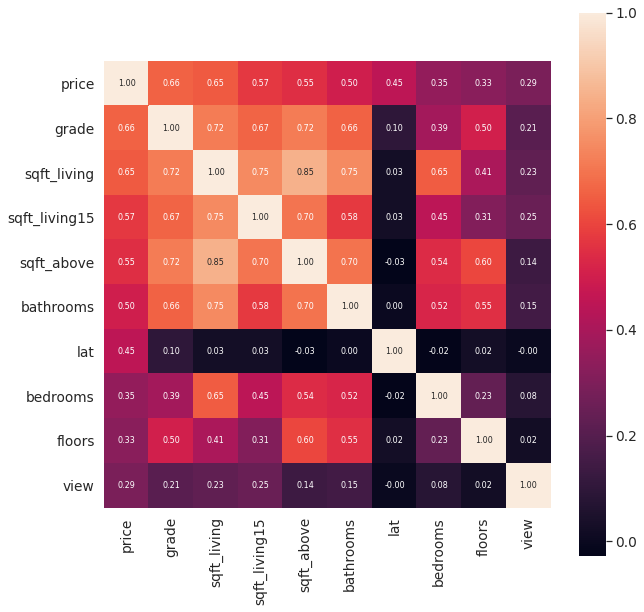

In [4]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price와 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [5]:
# data = data[['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view']]
# data
# sub = sub[['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view']]
# sub

In [6]:
# # 상관이 낮은 컬럼 제거
# data = data.drop(['sqft_living15', 'view'], axis = 1)
# sub = sub.drop(['sqft_living15', 'view'], axis = 1)

In [7]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [8]:
# ## 전진 단계별 선택법
# import statsmodels.api as sm

# variables = data.drop(['price'], axis = 1).tolist() ## 설명 변수 리스트
 
# y = data['price'] ## 반응 변수
# selected_variables = [] ## 선택된 변수들
# sl_enter = 0.05
# sl_remove = 0.05
 
# sv_per_step = [] ## 각 스텝별로 선택된 변수들
# adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
# steps = [] ## 스텝
# step = 0
# while len(variables) > 0:
#     remainder = list(set(variables) - set(selected_variables))
#     pval = pd.Series(index=remainder) ## 변수의 p-value
#     print(pval)
#     ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
#     ## 선형 모형을 적합한다.
#     for col in remainder: 
#         X = data[selected_variables+[col]]
#         X = sm.add_constant(X)
#         y = np.asarray(y)
#         X = np.asarray(X)
#         model = sm.OLS(y,X).fit()
#         pval[col] = model.pvalues[col]
 
#     min_pval = pval.min()
#     if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
#         selected_variables.append(pval.idxmin())
#         ## 선택된 변수들에대해서
#         ## 어떤 변수를 제거할지 고른다.
#         while len(selected_variables) > 0:
#             selected_X = data[selected_variables]
#             selected_X = sm.add_constant(selected_X)
#             selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
#             max_pval = selected_pval.max()
#             if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
#                 remove_variable = selected_pval.idxmax()
#                 selected_variables.remove(remove_variable)
#             else:
#                 break
        
#         step += 1
#         steps.append(step)
#         adj_r_squared = sm.OLS(y,sm.add_constant(data[selected_variables])).fit().rsquared_adj
#         adjusted_r_squared.append(adj_r_squared)
#         sv_per_step.append(selected_variables.copy())
#     else:
#         break

In [9]:
y = data['price'] # 라벨 데이터 분리
del data['price'] # 라벨컬럼 삭제

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
#주의# 여러번 시도하면 concat으로 인해 데이터가 중첩됨
train_len = len(data)
data = pd.concat((data, sub), axis=0) # 전체 데이터 탐색을 위해 train, testdata 결합
print(train_len) # 추후 train_test 분할을 위한 row 저장
print(len(data)) # 라벨을 제거하고 결합한 데이터의 row수

15035
21503


In [11]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

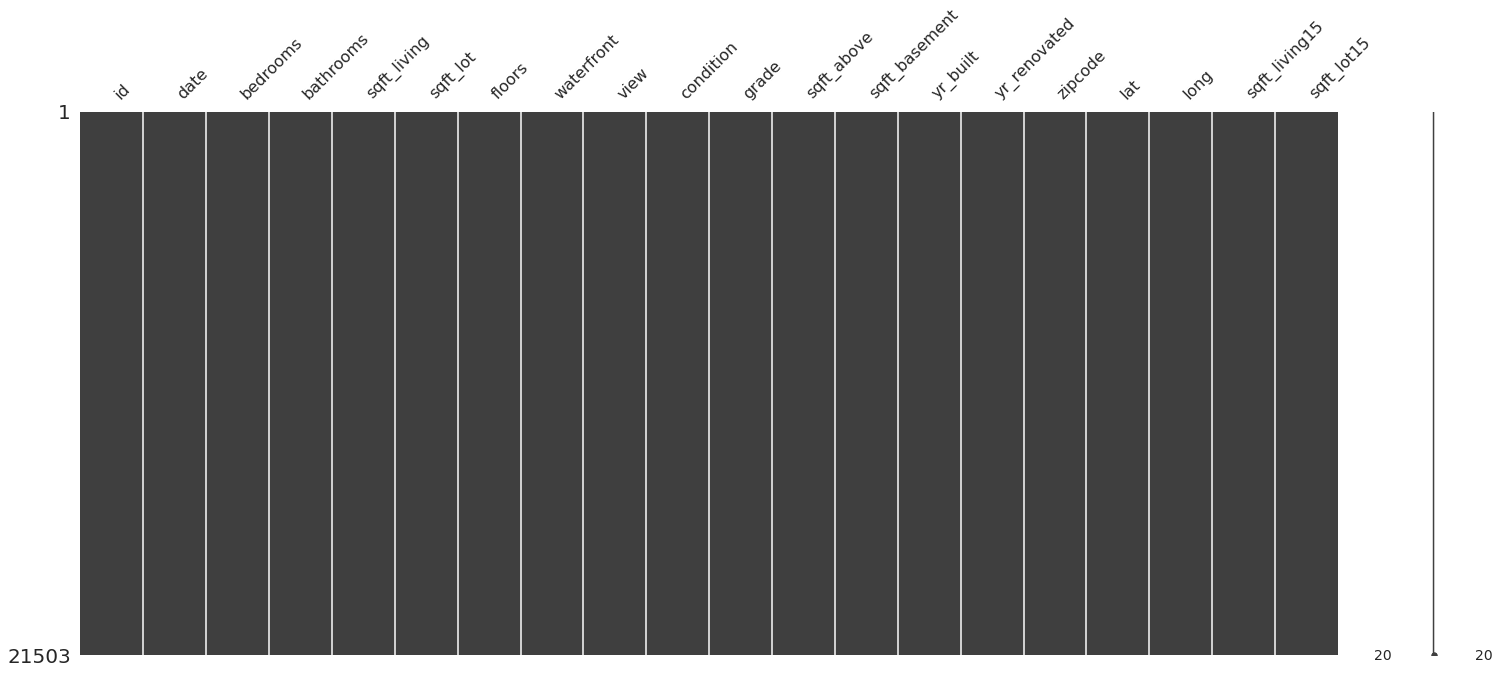

In [12]:
msno.matrix(data)

수치로 나타내보겠습니다.

In [13]:
# col 수만큼 for문을 돌려서 isnull값 출력 / 전체 컬럼을 한번에 출력하는 함수는 없나?
for col in data.columns:
    print('{} : {}'.format(col, len(data.loc[pd.isnull(data[col]), col].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.
date 변수는 년월일시간으로 값을 가지고 있는데, 년월만 고려하는 범주형 변수로 만듭니다.
 * 년월로 범주화하면 경향을 찾아내는데 도움을 주기때문이겠죠..??

In [14]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 꼬인 분포들을 풀어줍니다.

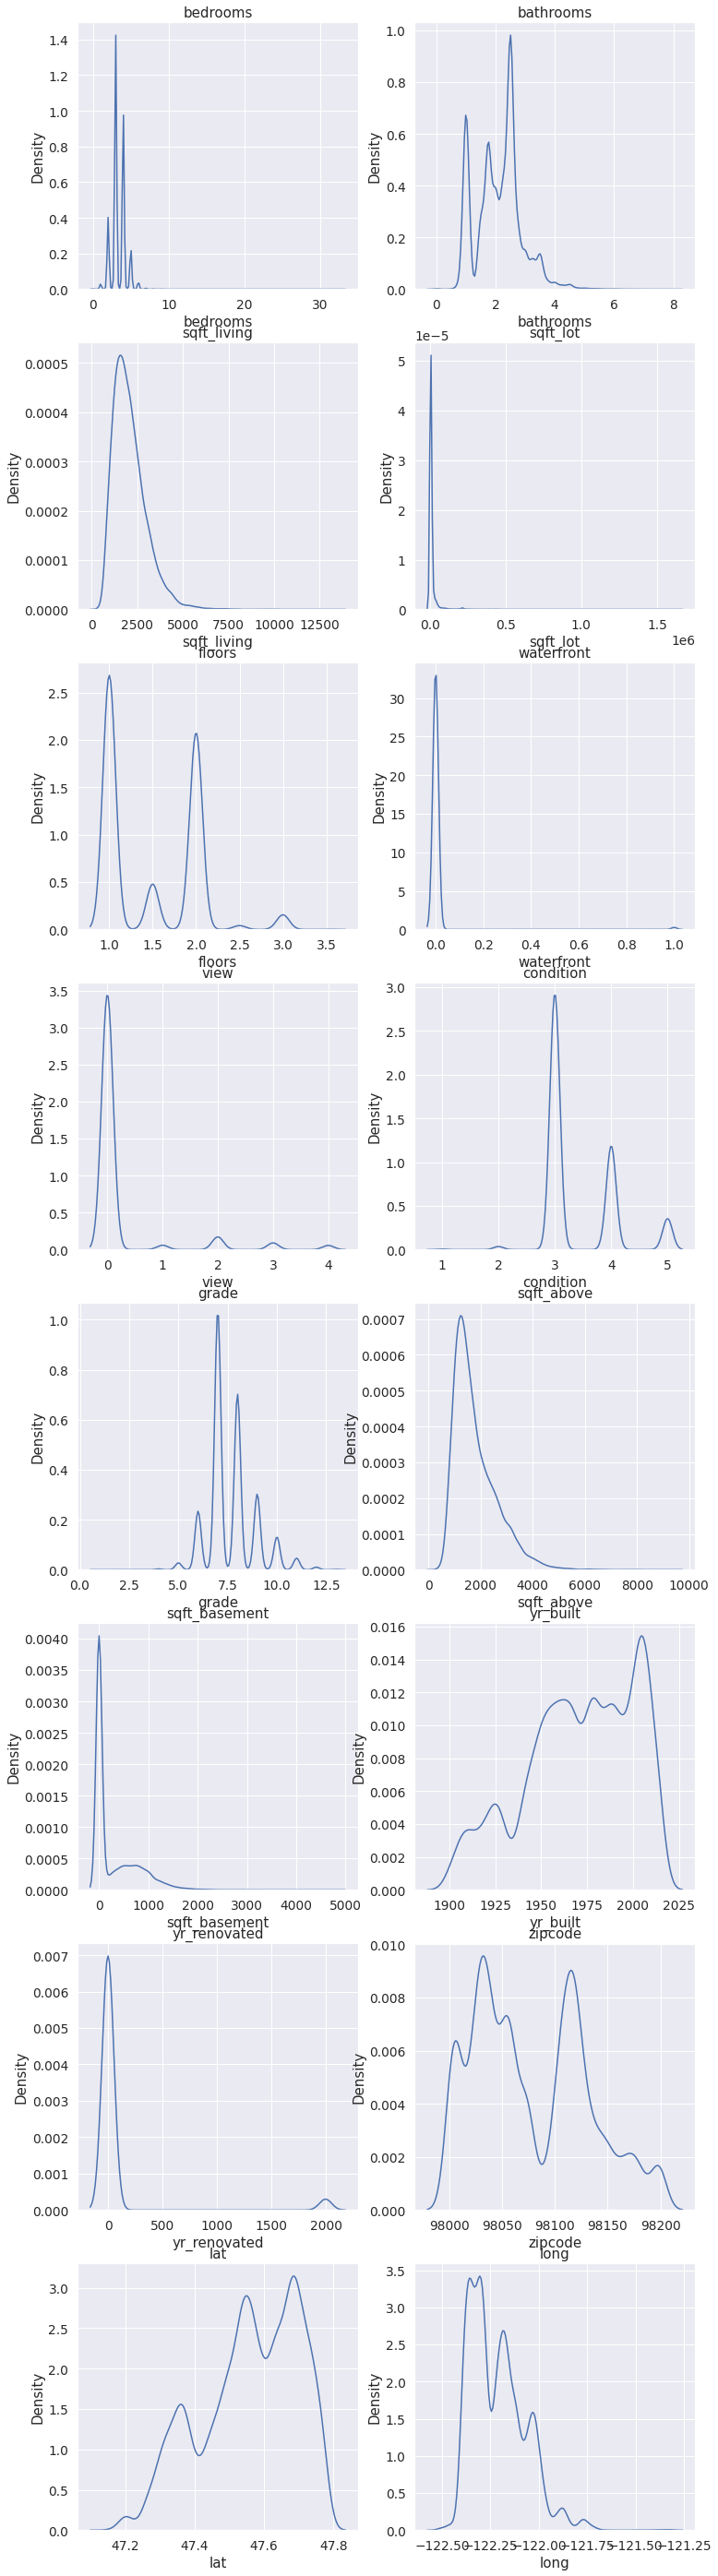

In [15]:
fig, ax = plt.subplots(8, 2, figsize=(12, 50))

# id 변수 및 datetime(str, count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(8):
    for col in range(2): # 10행 2열의 subplot에 그래프를 그리기 위해 2중 for문 사용
        sns.kdeplot(data[columns[count]], ax=ax[row][col]) # 이산데이터의 경우에도 부드러운 곡선으로 그려줌
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [16]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns: #표준화
    data[c] = np.log1p(data[c].values) # 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수

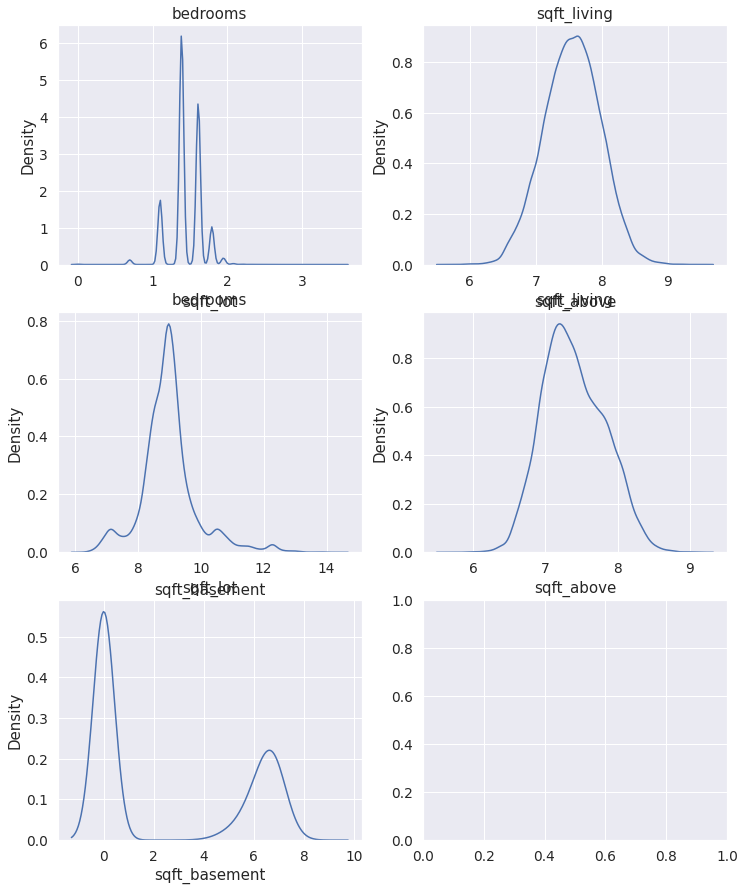

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



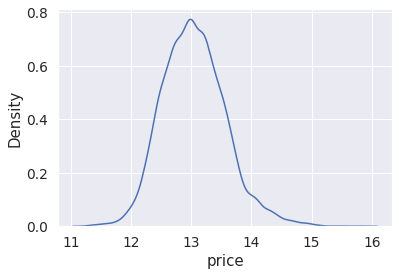

In [18]:
# 가격에도 log를 취해줌
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

정규화된 분포를 확인할 수 있습니다.

In [19]:
# 전처리 끝난 데이터 합치기
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 *Blending 모델을 만들겠습니다.
 * *여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 기법 활용( = 앙상블기법)

In [20]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

# 모델을 선언하고 딕셔너리에 저장
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [21]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [22]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

 * AgeragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환

In [23]:
# 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 함수
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y) # pandas도 딕셔너리처럼 keys, values로 접근가능(괄호는 생략해야하는듯)
    
    predictions = np.column_stack([ # np.column_stack([a, b])은 두 1차원배열 a, b를 column기준으로 붙여줌
        m['model'].predict(sub_x.values) for m in models # sub_x.values(test data)를 사용하여 예측
    ])
    return np.mean(predictions, axis=1)

In [24]:
y_pred = AveragingBlending(models, x, y, sub)

In [25]:
# 제출 형식에 맞게 데이터프레임 생성
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [26]:
sub.to_csv('submission.csv', index=False)

In [27]:
# # 위와 동일한 코드, 보다 풀어서 설명
# my_submission_path = join(data_dir, 'submission.csv')
# result.to_csv(my_submission_path, index=False)

# print(my_submission_path)

### 내 입맛대로 데이터 준비하기

#### 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝
 * 하이퍼 파라미터를 튜닝해보면서 모델 최적화

### 데이터 로드 및 preprocessing

In [28]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train = train.drop('sqft_living15', axis = 1)
test = test.drop('sqft_living15', axis = 1)

print('얍💢')

얍💢


In [29]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,9711


In [30]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # int형으로 변환하여 date컬럼까지 분석에 활용
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,9711


In [31]:
# 레이블 분리
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_lot15'],
      dtype='object')


In [32]:
# id 제거
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_lot15'],
      dtype='object')


In [33]:
# date변수의 년, 월까지 사용하기 위해 int타입으로 변환
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_lot15'],
      dtype='object')


In [34]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

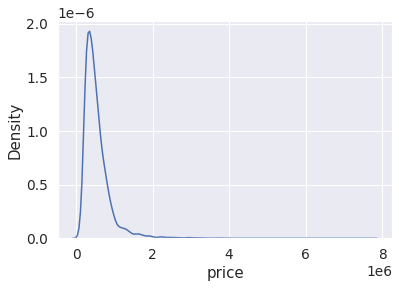

In [35]:
# 타겟변수 분포확인
sns.kdeplot(y)
plt.show()

In [36]:
# y는 np.log1p() 함수를 통해 로그 변환을 해주고, 모델이 값을 예측한 후에 다시 np.exp1m()을 활용하여 복원
# np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

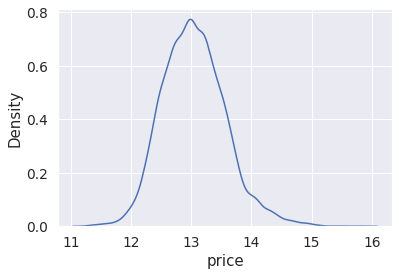

In [37]:
sns.kdeplot(y)
plt.show()

In [38]:
# 전체 데이터 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_lot15     15035 non-null  int64  
dtypes: flo

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


* 대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 구현
* RMSE = exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취함
*  **y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 함**

In [40]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [41]:
# 모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [42]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [43]:
gboost.__class__.__name__
type(gboost.__class__.__name__)

str

In [44]:
xgboost.__class__.__name__

'XGBRegressor'

In [45]:
lightgbm.__class__.__name__

'LGBMRegressor'

In [46]:
rdforest.__class__.__name__

'RandomForestRegressor'

### 저장한 모델을 이름으로 접근하여 추출 및 사용

In [47]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
#print(df.shape)
print(score_df.shape)
print(df)

(4, 1)
{'GradientBoostingRegressor': 131744.12963449786, 'XGBRegressor': 111544.14598658329, 'LGBMRegressor': 110212.60755603209, 'RandomForestRegressor': 125541.58519657851}


### 위의 내용을 함수로 만들어서 활용

In [48]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        x_train, x_test, y_train, y_test = train_test_split(train, y, random_state = random_state, test_size = 0.2)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index = ['RMSE']).T.sort_values('RMSE', ascending = False)
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,131744.129634
RandomForestRegressor,125541.585197
XGBRegressor,111544.145987
LGBMRegressor,110212.607556


# (3) 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

In [49]:
from sklearn.model_selection import GridSearchCV

### GridSearchCV에 입력되는 인자

* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
  * 여기 입력한 파라미터의 경우의 수를 모두 구함
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양
  * 숫자가 클수록 더 많은 메세지를 출력
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

### 하이퍼 파라미터 설정

In [50]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 훈련
    grid_model.fit(train, y)

    # 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터프레임으로 만들어줌
    results = pd.DataFrame(params)
    results['score'] = score

    # RMLSE값 저장(score값(1/n*error^2)에 -를 취해주고 루트를 씌움
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### (4) 제출하는 것도, 빠르고 깔끔하게!

그리드 탐색

In [54]:
param_grid = {
    'n_estimators': [500, 600, 700],
    'max_depth': [60, 80, 200],
    'learning_rate': [0.1],
    'num_leaves': [4, 8, 16],
    #'boosting': ['dart'],
    'num_iterations': [1200, 1300, 1500]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.9s finished


,learning_rate,max_depth,n_estimators,num_iterations,num_leaves,score,RMSLE
0,0.1,200,700,1500,8,-0.025903,0.160945


### 위 결과 가장 좋은 성능을 보인 하이퍼 파라미터로 모델 학습

 * LGBM은 트리 기반의 학습알고리즘으로 leaf-wise-tree-growth 방식에 속함
 * 이는 level-wise 방식에 비해 낮은 loss를 보이는 경향이 있음
 * 데이터 수가 부족할 때 과적합의 우려가 있기 때문에 max-depth를 조절할 필요가 있음
 
 * 장점 : 빠르다, 메모리를 적게 사용한다, gpu의 사용이 가능하다, 정확도가 높다
 * 단점 : over fitting의 위험때문에 데이터의 수가 많을 때 유리
   * 경험적으로 10,000개 이상일 때 추천

In [52]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""
#model 설정
model = LGBMRegressor(max_depth=200, n_estimators=700, learning_rate=0.10, num_leaves = 8, num_iterations = 1500, random_state=random_state)
# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle):
    
    #모델 훈련
    model.fit(train, y)
    # test를 사용해 예측
    prediction = model.predict(test)
    # price 복구
    prediction = np.expm1(prediction)
    # 제출 파일 저장, 파일명에 모델명과 RMSLE값 표기
    data_dir = os.getenv("HOME")+"/aiffel/kaggle_kakr_housing/data"
    submission_path = join(data_dir, "sample_submission.csv")
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)

In [53]:
save_submission(model, train, y, test, 'lgbm', rmsle='120595.692899')

# 9-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

튜닝해볼 수 있는 모델 클래스 인자
* max_depth : 의사 결정 나무의 깊이, 정수 사용
* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력


## 프로젝트 루브릭

### 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 주어진 노드를 활용하여 데이터 탐색 및 전처리, 모델링, 학습 및 예측 등 일련의 과정을 진행하였습니다.

### 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 일련의 과정을 차례대로 진행하였으며, 우선 3개의 모델을 학습시킨 앙상블 모형을 시도하고, 이후 LGBM을 통한 하이터 파라미터 최적화를 진행하였습니다. 

### 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?
* 다양한 시도를 통한 기준치 이상의 스코어를 달성하였습니다.

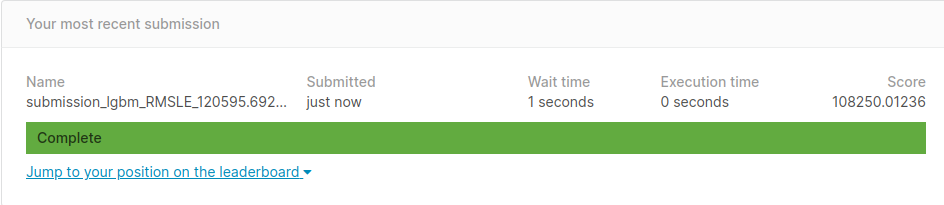

# 점수기록

#### 아래의 시도 이외에도 다양한 시도를 함

노드에서 주어진 estimators, depth, learning_rate를 바꿔가며 한 다양한 시도는 별다른 수확이 없었음
탐색한 하이퍼 파라미터(이외에도 많은 실험을 함)

param_grid = 
* 'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 1000],

* 'max_depth': [1, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500],    
    
* 'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.005, 0.01, 0.05, 0.1, 0.5]}

  * 0.164399 = 115688.17397

  * 0.161828 = 115201.78826

  * 129645.49035

  * 0.161079 = 115936.95282
  
  * 0.160684 = 116199.45015

## 회고

처음엔 단순히 회귀분석에서 사용하듯 여러 변수들을 비교하고, 영향의 정도를 파악해서 타겟변수에 많은 영향을 미치는 변수들을 위주로 돌리면 되겠거니 생각하고 여유를 부렸습니다. 모델의 구성도 이번 노드는 따라만 하면 될것 같았지만 생각보다 많은 시간이 걸렸습니다.
가장 큰 문제는 변수선택에 대한 모듈이 존재하지 않는다는 것이었습니다!(이걸 구현해보겠다고 시간좀 잡아먹었습니다..ㅠ)

모델에 대한 이해도 부족했고, 노드는 단순히 따라 옮기기만 했기때문에 코드를 바꿔보기조차 어려웠습니다. 그래서 생각한것보다 점수가 나오지 않았을때부터 처음부터 다시 읽어보고 변화를 시도했습니다. LGBM모델을 바탕으로 기존 노드에서 제시한 3가지 하이퍼 파라미터를 수정하였습니다. 그러나 수차례 시도한 결과가 2*2의 단순한 grid search보다 점수가 낮았습니다. 기록한 점수 이외에도 수많은 시도를 했지만 성능의 향상이 없었습니다. 그러다 다른 하이퍼 파라미터를 검색해서 추가해본 결과, 기준 점수보다 높은 성능을 낼 수 있었습니다.

여러가지 하이퍼 파라미터가 있지만, 그중에서도 성능에 영향을 미치는 우선순위가 있다는 것을 알게 되었습니다. 예를들어 learning_rate, num_iterations, max_depth, boosting등이 성능을 개선하는데 다른 파라미터에 비해 영향을 많이 준다는 사실을 알 수 있었습니다. 